# Loading Dataset

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as  np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import requests
import json
import cv2

In [2]:
train_ds = tfds.load('oxford_flowers102', split='train', shuffle_files=True)
test_ds = tfds.load('oxford_flowers102', split='test', shuffle_files=True)
val_ds = tfds.load('oxford_flowers102', split='validation', shuffle_files=True)
print(train_ds)
print(val_ds)
print(test_ds)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete5AIQT6/oxford_flowers102-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete5AIQT6/oxford_flowers102-test.tfrecord*...: …

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete5AIQT6/oxford_flowers102-validation.tfrecord…

Dataset oxford_flowers102 downloaded and prepared to ~/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
<PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
<PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
<PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [3]:
dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
# print shapes of 3 firs images
for feature, label in dataset['train'].take(5):
    print(feature.shape)

(500, 667, 3)
(500, 666, 3)
(670, 500, 3)
(500, 505, 3)
(500, 672, 3)


In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
    in the United Kingdom. Each class consists of between 40 and 258 images. The images have
    large scale, pose and light variations. In addition, there are categories that have large
    variations within the category and several very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set.
    The training set and validation set each consist of 10 images per class (totalling 1020 images each).
    The test set consists of the remaining 6149 images (minimum 20 per class).
    
    Note: The dataset by default comes with a test size larger than the train
    size. For more info see this [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    data

In [5]:
# Print out dataset info
print(f"Number of training data points: {dataset_info.splits['train'].num_examples}")
print(f"Number of testing data points: {dataset_info.splits['test'].num_examples}")
print(f"Number of validation data points: {dataset_info.splits['validation'].num_examples}")
no_classes = dataset_info.features['label'].num_classes
print(f"number of classes: {no_classes}")

Number of training data points: 1020
Number of testing data points: 6149
Number of validation data points: 1020
number of classes: 102


In [6]:
# apping the number label to actual names of the flowers
file_location='https://github.com/CheloGE/ML-tensorflow-Image_classifier-oxford_flowers102/blob/master/label_map.json?raw=1'
r = requests.get(file_location, stream=True)
class_names=json.loads(r.content.decode('utf-8'))
class_names = {int(k):v for k,v in class_names.items()}

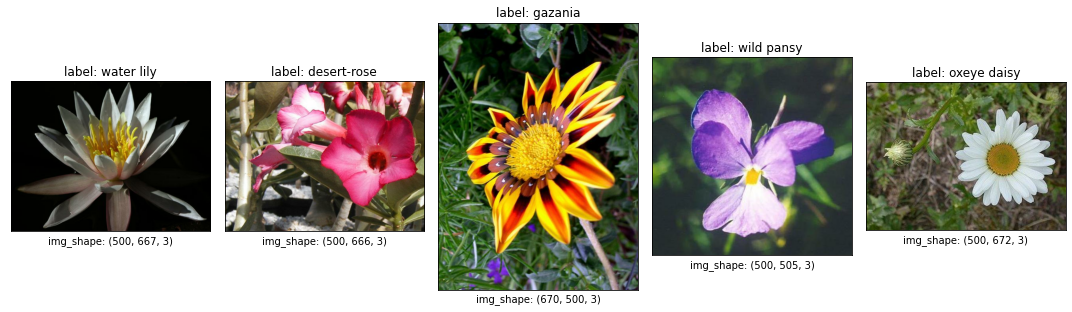

In [7]:
fig = plt.figure(figsize=(15,15))
i=0
for image, label in dataset['train'].take(5):
    ax = fig.add_subplot(1,5,i+1)
    ax.set_xticks([])
    ax.set_yticks([]) 
    plt.imshow(image)
    plt.title(f"label: {class_names[label.numpy()+1]}")
    plt.xlabel(f"img_shape: {image.shape}")
    i=i+1;
fig.tight_layout()

# Augmentation

- Fliping
- Rotation
- shifting

In [8]:
IMG_SIZE = 224

img_processing = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE)
])

img_augmentation = tf.keras.Sequential([
          tf.keras.layers.RandomFlip("horizontal"),
          tf.keras.layers.RandomRotation(factor=0.2),
          tf.keras.layers.RandomZoom(height_factor=(-0.2,-0.3), width_factor=(-0.2,-0.3)),
          tf.keras.layers.RandomBrightness((-0.2,0.2), value_range=[0,1])],
        name='img_augmentation'
        )

In [9]:
def flip(image):
    x = tf.image.random_flip_left_right(image)
    x = tf.image.random_flip_up_down(image)
    return x
def rotate(image):
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

# Preprocessing

In [10]:
IMG_SIZE=224

def image_resize(image,size=(IMG_SIZE,IMG_SIZE)):
    return tf.image.resize(image, size)

In [11]:
def normalalization(image,a=0,b=1,minPix=[0], maxPix=[255]):
    a = tf.constant([a], dtype=tf.float32)
    b = tf.constant([b], dtype=tf.float32)
    min_pixel = tf.constant(minPix, dtype=tf.float32)
    max_pixel = tf.constant(maxPix, dtype=tf.float32)

    return a + (((image - min_pixel)*(b - a) )/(max_pixel - min_pixel))

In [12]:
def encoding(labels, no_classes=102):
    return tf.one_hot(labels, no_classes)

In [13]:
def preprocess_data(vals,encode=True):
    # print(vals)

    # print(vals['image'])
    features = img_processing(vals['image'])
    if(encode):
      labels = encoding(vals['label'])
    else:
      labels=tf.cast(vals['label'], tf.int32)
    return features, labels

In [14]:
def preprocess_data_train(vals,encode=True):
    features = img_augmentation(img_processing(vals['image']))

    if(encode):
      labels = encoding(vals['label'])
    else:
      labels=tf.cast(vals['label'], tf.int32)
    return features, labels

In [15]:
buffer_size=2048
batch_size=32
processed_train_ds = train_ds.map(lambda x : preprocess_data_train(x,encode=False),num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
processed_val_ds = val_ds.map(lambda x: preprocess_data(x,encode=False),num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)
processed_test_ds = test_ds.map(lambda x: preprocess_data(x,encode=False),num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)

In [16]:
NUM_TRAINING_IMAGES = dataset_info.splits['train'].num_examples
NUM_VALIDATION_IMAGES = dataset_info.splits['validation'].num_examples
NUM_TEST_IMAGES = dataset_info.splits['test'].num_examples
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // batch_size
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 1020 training images, 1020 validation images, 6149 unlabeled test images


In [17]:
print("Training data shapes:")
for image, label in processed_train_ds.take(1):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in processed_test_ds.take(1):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in processed_val_ds.take(1):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy())

Training data shapes:
(32, 224, 224, 3) (32,)
Training data label examples: [52 83  7 24 91  9 53 72 22 36 54 52 66 66 61 93 86 54 26 51 82 42 77  8
  1 36 56 44 36 85 22 54]
Validation data shapes:
(32, 224, 224, 3) (32,)
Validation data label examples: [95 72 49 75 57 75 77 45 45 24 95 65 89 72 73 88 40 76 42 63 94 45 94 19
 51 46 73 70 72 93 89 10]
Test data shapes:
(32, 224, 224, 3) (32,)
Test data IDs: [88 54  8 37 13 52 29 67 94  7 75 58 88 89 87 86 12 83 18  5 84 85 84 81
 77 34 57 44 79 80 58 78]


After Augmentation

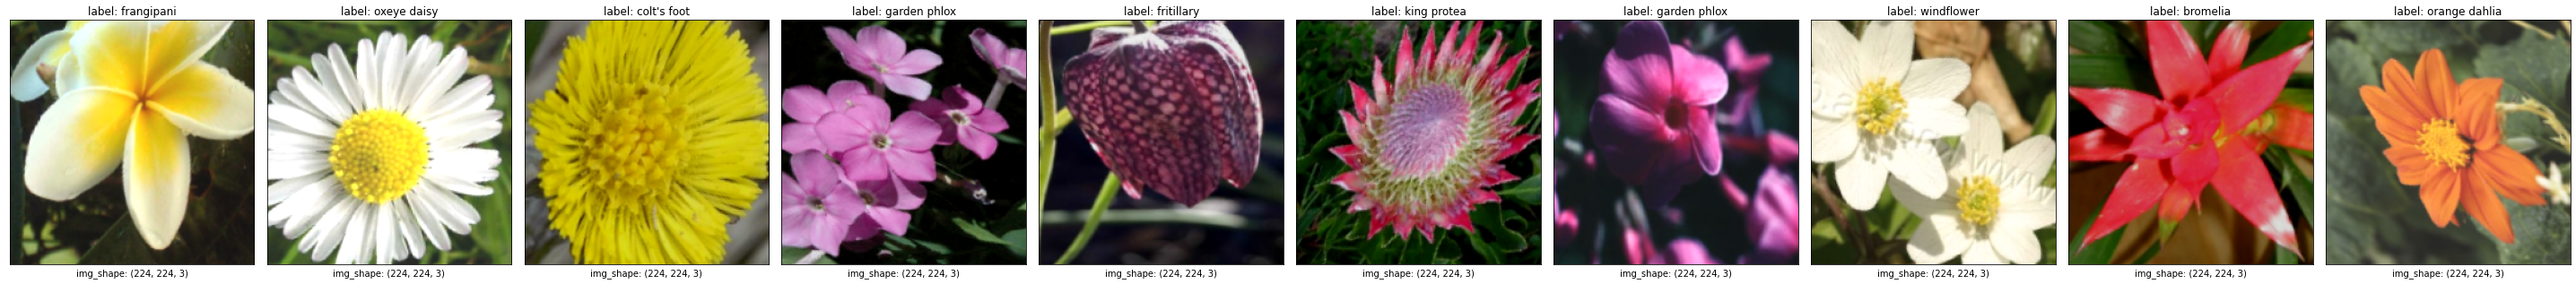

In [18]:
# Afteer preprocessing
fig = plt.figure(figsize=(40,40))
i=0
for j,k in processed_train_ds.take(1):
  for image, label in zip(j,k):
      if(i>=10):
        break
      ax = fig.add_subplot(1,10,i+1)
      ax.set_xticks([])
      ax.set_yticks([]) 
      plt.imshow(image)
      # plt.title(f"label: {class_names[np.where(label.numpy() == 1)[0][0]+1]}")
      plt.title(f"label: {class_names[label.numpy()+1]}")

      plt.xlabel(f"img_shape: {image.shape}")
      i=i+1;
  fig.tight_layout()

# Fine Tuning BiT Model to get BaseLine Accuracy based on SOTA training method

https://tfhub.dev/google/collections/bit/1





In [19]:
import tensorflow as tf
import pandas as pd
import numpy as  np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import requests
import json
import cv2

### Available BiT modules in Tensorflow Hub 
(https://tfhub.dev/google/collections/bit/1)

- BiT-S : pre-trained on ImageNet-1 dataset
- BiT-M : pre-trained on ImageNet-21k dataset -> *We will be using this through out the notebook*
- BiT-L :  pre-trained on JFT-300M dataset

Each Model have Various verions in which they use different types of Resnet Achitectures for featrure Extraction

- ResNet-50 (R50x1) 
- ResNet-50 (R50x3)
- ResNet-101 (R101x1)-> *We will be using this through out the notebook*
- ResNet-101 (R101x3)
- ResNet-152 (R152x4)



Paper : A. Kolesnikov, L. Beyer, X. Zhai, J. Puigcerver, J. Yung, S. Gelly and N. Houlsby: Big Transfer (BiT): General Visual Representation Learning.(https://arxiv.org/abs/1912.11370.pdf)

In [20]:
import tensorflow_hub as hub
# Load model from TFHub into KerasLayer
# We are loadind the BiT m-50x1, where it is pretrained on Imagenet 21K dataset with  ResNet-50 (R50x1) achitecture for feature extraction 
model_url = "https://tfhub.dev/google/bit/m-r101x1/1"
module = hub.KerasLayer(model_url)

To create the new model, we:

1. Remove the BiT model’s last layer. This leaves us with the “pre-logits” output.
 - We do not have to do this if we use the ‘feature extractor’ models ((i.e. all those in subdirectories titled `feature_vectors`), since for those models the head has already been cut off.

2. Add a new layer with the number of classes of our new dataset. Note that it is important that we initialise the layer to all zeroes.

In [21]:
class BiT(tf.keras.Model):
  """Custom BigTransfer (BiT): State-of-the-art transfer learning for computer vision.ipynb"""

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.softmax = tf.keras.layers.Dense(num_classes,kernel_initializer='zeros')
    self.bit_model = module

  def call(self, images):
    # No need to remove last layer since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    return self.softmax(bit_embedding)

model = BiT(num_classes=102, module=module)

In BiT-HyperRule, we use a vanilla SGD optimiser with an initial learning rate of 0.003, momentum 0.9. We decay the learning rate by a factor of 10 at 30%, 60% and 90% of the training steps. 


In [22]:
NUM_TRAINING_IMAGES = dataset_info.splits['train'].num_examples 
NUM_VALIDATION_IMAGES = dataset_info.splits['validation'].num_examples
NUM_TEST_IMAGES = dataset_info.splits['test'].num_examples
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // batch_size
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 1020 training images, 1020 validation images, 6149 unlabeled test images


In [23]:
# we are using fine-tune the model, we use BiT-HyperRule heuristic for choosing hyperparameters for downstream fine-tuning which was described by google research paper
lr = 0.003
EPOCHS=15
SCHEDULE_BOUNDARIES = [int(STEPS_PER_EPOCH*EPOCHS*0.3),int(STEPS_PER_EPOCH*EPOCHS*0.6),int(STEPS_PER_EPOCH*EPOCHS*0.9)]
epoch = 10
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES,
                                                                  values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)


In [24]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
             loss=loss_fn,
             metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpoint_filepath = '/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)



# Fine-tune model
history = model.fit(
    processed_train_ds,
    batch_size=batch_size,
    epochs= epoch,  
    callbacks=[early_stopping,model_checkpoint_callback],
    validation_data=processed_val_ds) 
       

Epoch 1/10
32/32 [==============================] - 70s 747ms/step - loss: 1.7503 - accuracy: 0.6569 - val_loss: 0.2564 - val_accuracy: 0.9461
Epoch 2/10
32/32 [==============================] - 31s 661ms/step - loss: 0.1609 - accuracy: 0.9647 - val_loss: 0.2175 - val_accuracy: 0.9637
Epoch 3/10
32/32 [==============================] - 30s 679ms/step - loss: 0.0185 - accuracy: 0.9931 - val_loss: 0.1170 - val_accuracy: 0.9784
Epoch 4/10
32/32 [==============================] - 30s 677ms/step - loss: 0.0099 - accuracy: 0.9980 - val_loss: 0.0979 - val_accuracy: 0.9824
Epoch 5/10
32/32 [==============================] - 29s 635ms/step - loss: 0.0071 - accuracy: 0.9980 - val_loss: 0.1409 - val_accuracy: 0.9755
Epoch 6/10
32/32 [==============================] - 32s 646ms/step - loss: 0.0068 - accuracy: 0.9971 - val_loss: 0.1339 - val_accuracy: 0.9784
Epoch 7/10
32/32 [==============================] - 29s 634ms/step - loss: 0.0053 - accuracy: 0.9980 - val_loss: 0.1216 - val_accuracy: 0.9784

In [25]:
results = model.evaluate(processed_test_ds, batch_size=batch_size)
print("test loss, test acc:", results)

193/193 [==============================] - 60s 309ms/step - loss: 0.1011 - accuracy: 0.9819
test loss, test acc: [0.10107891261577606, 0.9819482564926147]


In [ ]:
model.save_weights('./checkpoint/my_checkpoint')

In [ ]:
!zip -r checkpoint.zip /content/checkpoint 

updating: content/checkpoint/ (stored 0%)
  adding: content/checkpoint/my_checkpoint.index (deflated 81%)
  adding: content/checkpoint/checkpoint (deflated 49%)
  adding: content/checkpoint/my_checkpoint.data-00000-of-00001 (deflated 7%)


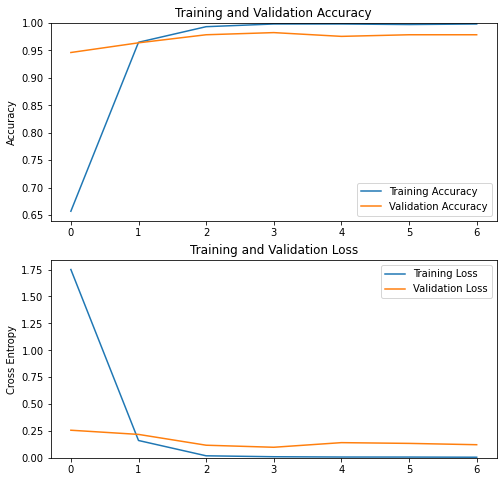

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#test_acc=[i[1] for i in test_callback.accuracy]
loss = history.history['loss']
val_loss = history.history['val_loss']
#test_loss=[i[0] for i in test_callback.accuracy]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.plot(test_acc, label='Test Accuracy')

plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title(f'Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.plot(test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title(f'Training and Validation Loss')
plt.show()

In [ ]:
# Show the MAX_PREDS highest scoring labels:
MAX_PREDS = 5
# Do not show labels with lower score than this:
MIN_SCORE = 0.8 

def show_preds(logits, image, correct_flowers_label=None):

  if len(logits.shape) > 1:
    logits = tf.reshape(logits, [-1])

  fig, axes = plt.subplots(1, 2, figsize=(7, 4), squeeze=False)

  ax1, ax2 = axes[0]

  ax1.axis('off')
  ax1.imshow(image)
  if correct_flowers_label is not None:
    ax1.set_title(class_names[correct_flowers_label+1])
  classes = []
  scores = []
  logits_max = np.max(logits)
  softmax_denominator = np.sum(np.exp(logits - logits_max))
  for index, j in enumerate(np.argsort(logits)[-MAX_PREDS::][::-1]):
    score = 1.0/(1.0 + np.exp(-logits[j]))
    if score < MIN_SCORE: break
    # predicting in tf_flowers label space
    classes.append(class_names[j+1])
    scores.append(np.exp(logits[j] - logits_max)/softmax_denominator*100)

  ax2.barh(np.arange(len(scores)) + 0.1, scores)
  ax2.set_xlim(0, 100)
  ax2.set_yticks(np.arange(len(scores)))
  ax2.yaxis.set_ticks_position('right')
  ax2.set_yticklabels(classes, rotation=0, fontsize=14)
  ax2.invert_xaxis()
  ax2.invert_yaxis()
  ax2.set_xlabel('Prediction probabilities', fontsize=11)

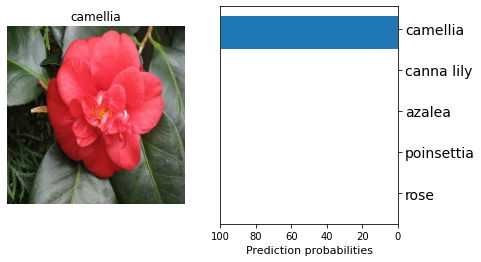

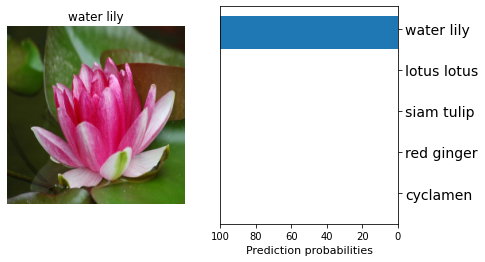

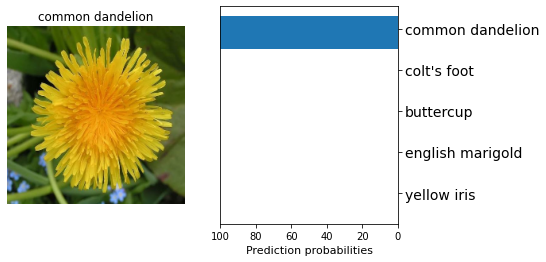

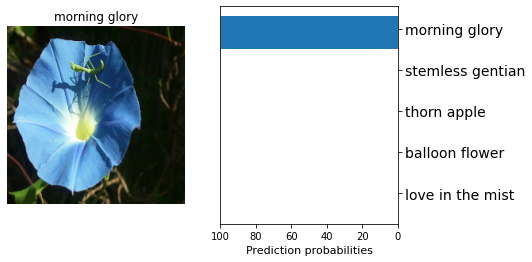

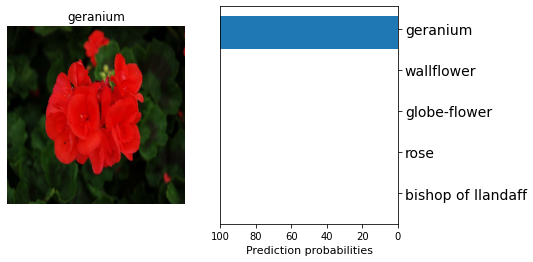

In [ ]:
# few examples for prediction on test dataset
for image,label in processed_test_ds.take(1):
  logits = model(image)
  for i,j,k in zip(image[:5],label[:5],logits[:5]):

    #  image and predictions
    show_preds(k, i, correct_flowers_label=j.numpy())

# Fine tuning to perform better than SOTA

- Change LR
- Change Optimizer(Adam with beta 1 tuning)
- Adding Droupouts
- Adding Dense Layer after feature Extraction
- Batch Size


#### Learning Rate Tuning

Adapting BiT-Hyperparameter Learning which was defined for 512 batch size to different batch size by normalizing the learning rate

- lr = 0.003 * batch_size/512

- Reducing steps per epoch 

In [29]:
# Learning Rate changes 
# Normalizing the learning rate
lr = 0.003 * batch_size/512
epoch =10
steps_per_epoch=epoch * len(processed_train_ds)
SCHEDULE_BOUNDARIES = [steps_per_epoch*epoch*0.3, steps_per_epoch*epoch*0.6, steps_per_epoch*epoch*0.9]
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES,
                                                                  values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)


In [ ]:
!pip install keras-tuner

In [30]:
class BiT(tf.keras.Model):
  """Custom BigTransfer (BiT): State-of-the-art transfer learning for computer vision.ipynb"""

  def __init__(self, num_classes, module,dense=False,neurons=1024,dropoutP=0.2):
    super().__init__()

    self.num_classes = num_classes
    self.dense =dense
    self.softmax = tf.keras.layers.Dense(num_classes,kernel_initializer='zeros')
    if(dense):
      self.dense = tf.keras.layers.Dense(neurons,activation='relu')
      self.dp = tf.keras.layers.Dropout(dropoutP)
    self.bit_model = module

  def call(self, images):
    # No need to remove last layer since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    if(self.dense):
      bit_embedding = self.dense(bit_embedding)
      bit_embedding = self.dp(bit_embedding)
    return self.softmax(bit_embedding)



## Tuning to see if additonal dense layer Required?

In [ ]:
# Load model into KerasLayer

model_url = "https://tfhub.dev/google/bit/m-r101x1/1"
module = hub.KerasLayer(model_url)

In [31]:
# Keras Tuner
import keras_tuner as kt
images_size=224
def model_tuning(tuner):

  # parameters
  # 1. Boolean to. add Dense layer or not - True,False
  # 2. No of neurons in Dense Layer to be adder - [512,1024,2048,4096]
  # 3. Dropout probability - 0.1, 0.5, sampling='linear'
    model = BiT(num_classes=102, module=module,
                dense = tuner.Choice("Dense Layer Added",values=[True,False]),
                neurons = tuner.Choice("Neurons in Dense Layer",values=[512,1024,2048,4096]),
                dropoutP=tuner.Float('Dropout Probability', 0.1, 0.5, sampling='linear'))

    # Initialize an Adam Optimizer with custom learning rate
    # Learning rate: min=1e-4, max=2e-1, sampling=’log’
    # Parameter no.3- Learning rate - 1e-5, 1e-2, sampling='log'
    lr = tuner.Float('Learning_rate', 1e-4, 1e-2, sampling='log',intial_value)
    # lr normalizin 
    lr *= batch_size/512
    epoch = 5
    steps_per_epoch=epoch * len(processed_train_ds)
    SCHEDULE_BOUNDARIES = [steps_per_epoch*epoch*0.3, steps_per_epoch*epoch*0.6, steps_per_epoch*epoch*0.9]
    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES,
                                                                      values=[lr, lr*0.1, lr*0.001, lr*0.0001])
    
    # parameter 4- Boolean to choose optimizer SGD(True) or Adam(False)
    if(tuner.Choice("SGD used or not",values=[True,False])):      
      optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
    else:
      # paramter 5- Beta_1 -  0.9 to 0.999
      optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule,
                                          beta_1=tuner.Float('Beta 1', 9e-1,1-1e-3, sampling='log')) 
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer,loss=loss_fn,metrics=['accuracy'])
    
    model.build(input_shape=(batch_size,images_size,images_size,3))

    print(model.summary())

    return model

In [34]:
# Initialize the BayesianOptimization tuner that will select the best model based on the objective
SEED=42
tuner = kt.BayesianOptimization(
    model_tuning,
    max_trials=10,
    objective='val_loss',
    project_name="BiT_hyperband",
    seed = SEED
)
tuner.search_space_summary()

# EarlyStopping callback of patiece 10 on val_loss
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Start the search with each iteration being of 50 epochs
tuner.search(processed_train_ds, validation_data=processed_val_ds, epochs=4, callbacks=[stop_early], verbose=2)

Trial 10 Complete [00h 02m 19s]
val_loss: 0.1853943169116974

Best val_loss So Far: 0.07798196375370026
Total elapsed time: 00h 24m 11s


In [ ]:
# Initialize the RandomSearch tuner that will select the best model based on the objective
SEED=42
tuner = kt.Hyperband(
    model_tuning,
    max_epochs=5,
    factor=3,
    objective='val_loss',
    hyperband_iterations=10,
    project_name="BiT_hyperband",
    seed = SEED
)
tuner.search_space_summary()

# EarlyStopping callback of patiece 10 on val_loss
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Start the search with each iteration being of 50 epochs
tuner.search(processed_train_ds, validation_data=processed_val_ds, epochs=5, callbacks=[stop_early], verbose=2)

Trial 18 Complete [00h 41m 55s]
val_loss: 0.1787319779396057

Best val_loss So Far: 0.15308818221092224
Total elapsed time: 00h 41m 55s

Search: Running Trial #19

Value             |Best Value So Far |Hyperparameter
1                 |0                 |Dense Layer Added
512               |4096              |Neurons in Dense Layer
0.48431           |0.15789           |Dropout Probability
0.0050139         |0.00030794        |Learning_rate
1                 |0                 |SGD used or not
0.9042            |0.91894           |Beta 1
5                 |5                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
0                 |0                 |tuner/bracket
0                 |0                 |tuner/round

Model: "bi_t"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  52326     
                                 

In [39]:
# best parameter from the tuner
best_hps = tuner.get_best_hyperparameters(1)[0]

print("------The Best Parameters are -------")
for param in best_hps.values:
  print("{} = {}".format(param,best_hps[param]))
print("-----------------------------------")


------The Best Parameters are -------
Dense Layer Added = 0
Neurons in Dense Layer = 4096
Dropout Probability = 0.4276455362315362
Learning_rate = 0.01
SGD used or not = 0
Beta 1 = 0.9
-----------------------------------


In [43]:
best_hps["Dense Layer Added"]

0

In [53]:
model = BiT(num_classes=102, module=module,
                dense =best_hps["Dense Layer Added"],
                neurons =best_hps["Neurons in Dense Layer"],
                dropoutP=best_hps["Dropout Probability"])
# model = BiT(num_classes=102, module=module,
#                 dense =True,
#                 neurons =1024,
#                 dropoutP=0.1)

lr = 0.003
# # lr normalizin 
# lr *= batch_size/512
epoch = 15
steps_per_epoch=epoch*len(processed_train_ds)
SCHEDULE_BOUNDARIES = [steps_per_epoch*epoch*0.3, steps_per_epoch*epoch*0.6, steps_per_epoch*epoch*0.9]
print(SCHEDULE_BOUNDARIES)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES,
                                                                  values=[lr, lr*0.1, lr*0.001, lr*0.0001])

# parameter 4- Boolean to choose optimizer SGD(True) or Adam(False)
if(True):      
  optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
else:
  # paramter 5- Beta_1 -  0.9 to 0.999
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule,
                                      beta_1=best_hps["Beta 1"]) 
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,loss=loss_fn,metrics=['accuracy'])
model.build(input_shape=(batch_size,IMG_SIZE,IMG_SIZE,3))
model.summary()

[2160.0, 4320.0, 6480.0]
Model: "bi_t_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             multiple                  208998    
                                                                 
 keras_layer (KerasLayer)    multiple                  42492480  
                                                                 
Total params: 42,701,478
Trainable params: 208,998
Non-trainable params: 42,492,480
_________________________________________________________________


In [54]:
# Fine-tune model
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    processed_train_ds,
    batch_size=batch_size,
    epochs= epoch,  
    callbacks=[early_stopping,model_checkpoint_callback],
    validation_data=processed_val_ds) 

Epoch 1/15
32/32 [==============================] - 35s 681ms/step - loss: 1.7049 - accuracy: 0.6559 - val_loss: 0.2585 - val_accuracy: 0.9392
Epoch 2/15
32/32 [==============================] - 29s 618ms/step - loss: 0.0942 - accuracy: 0.9814 - val_loss: 0.2022 - val_accuracy: 0.9627
Epoch 3/15
32/32 [==============================] - 29s 624ms/step - loss: 0.0355 - accuracy: 0.9902 - val_loss: 0.1349 - val_accuracy: 0.9696
Epoch 4/15
32/32 [==============================] - 30s 668ms/step - loss: 0.0096 - accuracy: 0.9971 - val_loss: 0.0971 - val_accuracy: 0.9794
Epoch 5/15
32/32 [==============================] - 32s 736ms/step - loss: 0.0026 - accuracy: 0.9990 - val_loss: 0.0919 - val_accuracy: 0.9745
Epoch 6/15
32/32 [==============================] - 29s 630ms/step - loss: 0.0066 - accuracy: 0.9971 - val_loss: 0.0935 - val_accuracy: 0.9784
Epoch 7/15
32/32 [==============================] - 30s 677ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0878 - val_accuracy: 0.9804

In [55]:
results = model.evaluate(processed_test_ds, batch_size=batch_size)
print("test loss, test acc:", results)

193/193 [==============================] - 59s 303ms/step - loss: 0.0817 - accuracy: 0.9850
test loss, test acc: [0.0817476138472557, 0.9850382208824158]


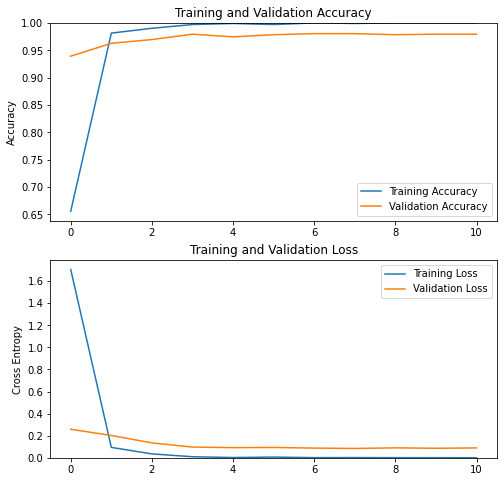

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#test_acc=[i[1] for i in test_callback.accuracy]
loss = history.history['loss']
val_loss = history.history['val_loss']
#test_loss=[i[0] for i in test_callback.accuracy]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.plot(test_acc, label='Test Accuracy')

plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title(f'Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.plot(test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title(f'Training and Validation Loss')
plt.show()